## README FILE

This notebook aims to concisely and comprehensibly describe the steps used throughout the our project.
In total, 2 Jupyter notebooks were developed, whose names are:

- **ML_regression.ipynb**
- **ML_classification.ipynb**

Let's analyze each one in detail.

##### ML_regression.ipynb

### Introduction
This Jupyter Notebook implements a machine learning pipeline for regression tasks in Python using various regression models from the scikit-learn, LightGBM, and CatBoost libraries. The code focuses on predicting properties of galaxies based on astronomical features. The process includes data preprocessing, model training, evaluation, and visualization of results.

### Code Overview

1. **Import Libraries:**
   - NumPy, pandas, seaborn, and matplotlib are used for data manipulation and visualization.
   - Time is used to measure the execution time.
   - CatBoost, LightGBM, and scikit-learn are used for regression models.



In [ ]:
import numpy as np 
from pandas import Series, DataFrame
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import catboost

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

2. **Data Loading and Preprocessing:**
   - The original catalog data is loaded from a parquet file.




In [ ]:
#original catalog
path = r'C:\Users\pedro\OneDrive - Universidade do Porto\Imagens\OneDrive - Universidade do Porto\Ambiente de Trabalho\UNI\Mestrado\1º semestre\Machine Learning\Projeto\dados\catalog.parquet'
catalog = pd.read_parquet(path)

   - Unreliable observations (rows with FLAG values equals to zero) are filtered out.


In [ ]:
# filter out unreliable observations
cata = catalog[catalog.filter(like='FLAG').eq(0).all(axis=1)] 

   - Features and labels are selected. 
       - Impose Redshift and SFR range
       - Features: All 44 magnitudes sources


In [ ]:
features = ['lp_zBEST']
for col_name in list(cata.columns.values):
        if 'MAG' in col_name: 
            features.append(col_name)

# List of labels
labels =['lp_mass_best','lp_SFR_best']

#choose only data from galaxies
cata = cata[cata['lp_type'] == 0] 

# labels range 
cata = cata.loc[(cata['lp_zBEST'] > 0.2) & (cata['lp_zBEST'] < 5.5)]  
cata = cata.loc[(cata['lp_SFR_best'] > -4) & (cata['lp_SFR_best'] < 3)]  

# new catalog
columns = features + labels
cat = cata[columns]

  - Drop every observation whose value is NaN for the labels

In [ ]:
cat = cat.dropna(subset=labels)  # Drop NaN in targets' columns

#final table
cat = cat.loc[cat.index] 

   - Data is split into training, validation, and test sets.

In [ ]:
X = cat[features] #features matrix
y = cat[labels]  #labels matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

3. **Model Training:**
   - Two regression models, LightGBM and CatBoost, are trained using the training set.




In [ ]:
models = [
    LGBMRegressor(
        objective='regression', 
        n_jobs=-1,
        n_estimators=1000,
        max_depth=8,
        subsample=0.8,
        reg_alpha=0.1,
        verbosity=-1
    ),
    CatBoostRegressor(
        loss_function='RMSE',   
        logging_level='Silent',
        n_estimators=1000,
        l2_leaf_reg=0.1,
        max_depth=8
    )
]

- MultiOutputRegressor is used to handle multiple target variables.

In [ ]:
pred_dict = {}

for i, method in enumerate(models):
    model_name = columns_df[i]
    print(f"\nTraining {model_name}...")

    start_time = time.time()

    regressor = MultiOutputRegressor(method)
    regressor.fit(X_train, y_train)
    pred = regressor.predict(X_val)

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Execution time for {model_name}: {execution_time:.2f} seconds")

    for j, label in enumerate(labels):
        col_name = model_name + '_' + label
        pred_dict[col_name] = pred[:, j]

pred_df = pd.DataFrame(pred_dict, index=y_val.index)

- Seeing the evolution of the loss of the CatBoostRegressor over the iterations.

In [ ]:
# Extract the loss values from the CatBoostRegressor
if isinstance(regressor.estimators_[0], CatBoostRegressor):
    evals_result = regressor.estimators_[0].evals_result_
    
    # Print the keys of evals_result to inspect its structure
    print("Keys of evals_result:", evals_result.keys())

    # Assuming the structure is evals_result_['learn'] or evals_result_['validation']
    if 'validation' in evals_result:
        loss_values = evals_result['validation']['RMSE']
    elif 'learn' in evals_result:
        loss_values = evals_result['learn']['RMSE']
    else:
        raise KeyError("Could not find 'validation' or 'learn' in evals_result")

    # Plot CatBoost loss values
    plt.plot(np.arange(1, len(loss_values) + 1), loss_values)
    plt.xlabel('Iteration')
    plt.ylabel('RMSE Loss')
    plt.title('CatBoost Loss Over Iterations')
    plt.grid()
    plt.xlim(-25, 1000)
    plt.show()


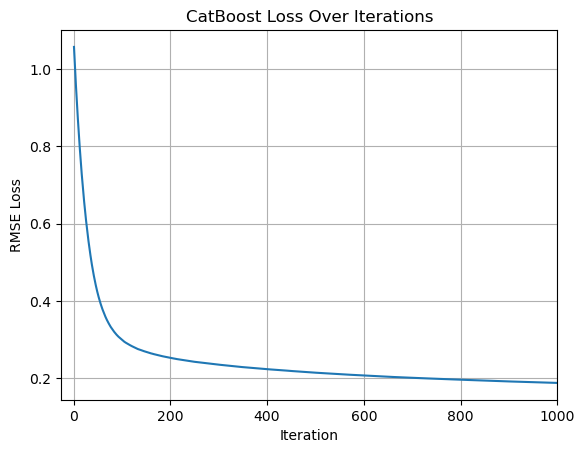

4. **Model Evaluation:**
   - Predictions are made on the validation set.
   - Histograms compare the actual values with the predicted values for each label.



In [ ]:
colors = ['cornflowerblue', 'darkorange', 'salmon']

for i, label in enumerate(labels):
    fig_hist, ax = plt.subplots(figsize=(7, 5))
    ax.hist(y_val[label], 35, facecolor=colors[0], edgecolor='black', alpha=0.7, label='catalog {}'.format(label), density=True)
    ax.hist(pred_df['lightgbm_{}'.format(label)], 35, facecolor=colors[1], edgecolor='black', alpha=0.5, label='lightgbm predicted {}'.format(label), density=True)
    ax.hist(pred_df['catboost_{}'.format(label)], 35, facecolor=colors[2], edgecolor='black', alpha=0.5, label='catboost predicted {}'.format(label), density=True)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel(label)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
    plt.show()

##### (e.g.)
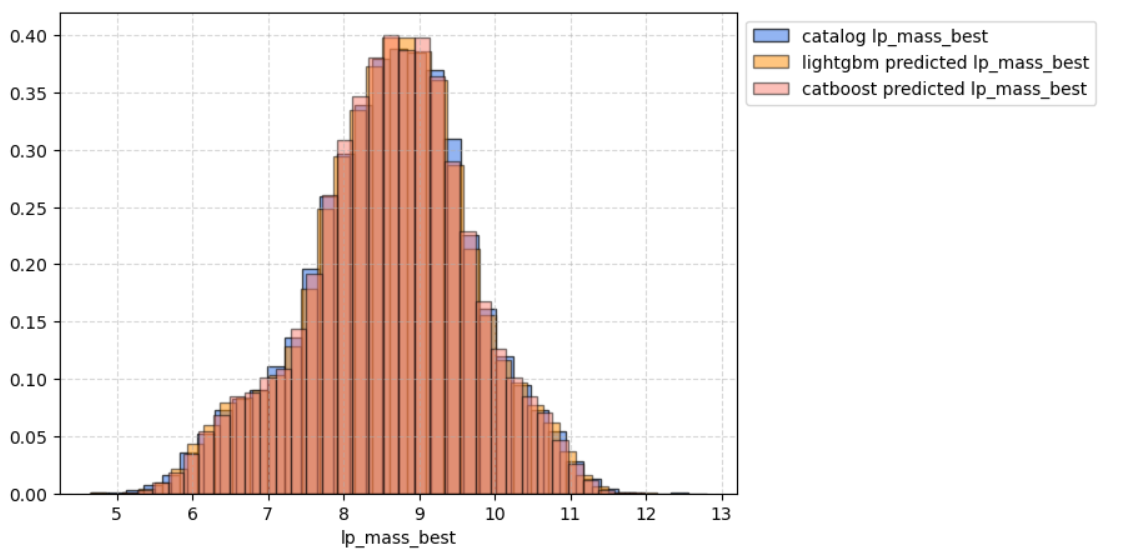

5. **Scatter Plot Visualization:**
   - Scatter plots visualize the relationship between true and predicted values for each model and label.



In [ ]:
models = ['catboost', 'lightgbm']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        # Create a 2D histogram with higher resolution (more bins)
        counts, x_edges, y_edges = np.histogram2d(y_val[label], pred_df['{}_{}'.format(model, label)], bins=200)
        
        # Mask areas with zero counts
        counts_masked = np.ma.masked_where(counts == 0, counts)
        
        # Plot the 2D histogram using a color map
        im = axes[i, j].imshow(counts_masked, extent=[y_edges[0], y_edges[-1], x_edges[0], x_edges[-1]], cmap="viridis", aspect="auto", origin="lower")

        
        # Add color bar
        cbar = fig.colorbar(im, ax=axes[i, j], label='Count')

        # Add a red dashed line for y=x
        axes[i, j].plot([min(y_val[label]), max(y_val[label])], [min(y_val[label]), max(y_val[label])], linestyle='--', color='red')

        axes[i, j].grid(True, linestyle='--', alpha=0.5)
        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()


6. **Feature Importance Plot:**
   - Feature importance is visualized for the first model (LightGBM) based on the first target variable.



In [ ]:
def plot_feature_importance(importance, names):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Normalize feature importance values
    normalized_importance = feature_importance / feature_importance.sum()

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': normalized_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Select only the top 10 features
    top_10_features = fi_df.head(10)

    # Define size of bar plot
    plt.figure(figsize=(10, 6))
    # Plot Seaborn bar chart
    sns.barplot(x=top_10_features['feature_importance'], y=top_10_features['feature_names'])
    # Add chart labels
    plt.title(' Top 10 Normalized Feature Importance')
    plt.xlabel('Normalized Feature Importance')
    plt.ylabel('Feature Names')

features_importances = regressor.estimators_[0].feature_importances_
names = X_train.columns

plot_feature_importance(features_importances, names)
plt.grid(True,alpha=0.15)

7. **Performance Metrics:**
   - Metrics such as NMAD (Normalized Median Absolute Deviation), bias, percentage of outliers, R², and MSE are calculated and printed for each model and label.


In [ ]:
def metrics(y, ŷ, outlier_threshold=0.3):
    
    f_out = np.abs(ŷ - y)
    nmad = 1.48 * np.median(f_out)
    # Calculate bias as the mean of the differences
    bias = np.mean(ŷ - y) 
    # Identify outliers
    is_outlier = f_out > outlier_threshold
    percentage_outliers = np.mean(is_outlier) * 100
    
    y_outlier = pd.Series(np.where(is_outlier, 'outlier', 'not outlier'))
    
    r2 = r2_score(y, ŷ)
    
    # Calculate Variance and check the relationship with MSE
    variance = np.var(ŷ)
    mse_check = variance + bias**2
    
    print(f"{y_outlier.value_counts()}")
    print(f"Percentage of values that are outliers: {percentage_outliers:.2f}%\n")
    print(f"Bias: {bias:.4f}\n")
    print(f"NMAD score: {nmad:.3f}\n")
    print(f"R²= {r2:.3f}\n")
    print(f'Variance = {variance:.4f}\n')
    print(f'MSE (calculated) = Variance + Bias^2: {mse_check:.4f}')


for label in labels:
    for model in models:
        print(f'-----------{model}-{label}-------------\n')
        metrics(y_val[label],pred_df[f'{model}_{label}'])
        print('\n')

   - Residues and its dependence with redshift

In [ ]:
fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3
        
        diff = y_val[label] - pred_df['{}_{}'.format(model, label)]
        
        axes[i, j].scatter(y_val[label], diff, s=marker_size, label='Residues')
        
        # 2*sy
        sy = np.std(np.sqrt(np.abs(y_val[label] - pred_df['{}_{}'.format(model, label)])))
        axes[i, j].hlines(2 * sy, min(y_val[label]), max(y_val[label]), color='red', linestyle='dashed', linewidth=2, label='2 * sy')
        axes[i, j].hlines(-2 * sy, min(y_val[label]), max(y_val[label]), color='red', linestyle='dashed', linewidth=2)
        
        axes[i, j].grid(True, linestyle='--', alpha=0.5)

        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Residues')

        axes[i, j].legend()

plt.tight_layout()
plt.show()

In [ ]:
models = ['catboost', 'lightgbm']

fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3

        diff = y_val[label] - pred_df['{}_{}'.format(model, label)]

        axes[i, j].scatter(X_val['lp_zBEST'], diff, s=marker_size, label='Residues')

        axes[i, j].grid(True, linestyle='--', alpha=0.5)

        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel(r'$Z$')
        axes[i, j].set_ylabel('Residues')

        axes[i, j].legend()

plt.tight_layout()
plt.show()

- We also plotted the graphs relative to the predictions vs real values with count colourbars to better observe the concentration of points in the different zones

In [ ]:
models = ['catboost', 'lightgbm']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        # Create a 2D histogram with higher resolution (more bins)
        counts, x_edges, y_edges = np.histogram2d(y_val[label], pred_df['{}_{}'.format(model, label)], bins=200)
        
        # Mask areas with zero counts
        counts_masked = np.ma.masked_where(counts == 0, counts)
        
        # Plot the 2D histogram using a color map
        im = axes[i, j].imshow(counts_masked, extent=[y_edges[0], y_edges[-1], x_edges[0], x_edges[-1]], cmap="viridis", aspect="auto", origin="lower")

        
        # Add color bar
        cbar = fig.colorbar(im, ax=axes[i, j], label='Count')

        # Add a red dashed line for y=x
        axes[i, j].plot([min(y_val[label]), max(y_val[label])], [min(y_val[label]), max(y_val[label])], linestyle='--', color='red')

        axes[i, j].grid(True, linestyle='--', alpha=0.5)
        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()


##### ML_classification.ipynb

### Introduction
This Jupyter Notebook contains a machine learning code written in Python using TensorFlow and scikit-learn. The goal of this code is to build a classification model to predict whether an astronomical object is a galaxy or a star based on certain features. The code includes data preprocessing, model building, training, evaluation, and visualization of the results.


### Code Overview

1. **Import Libraries:**
   - NumPy, pandas, and matplotlib are used for data manipulation and visualization.
   - scikit-learn is used for data preprocessing and splitting.
   - TensorFlow is used to build and train the neural network model.
 

In [ ]:
import numpy as np 
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os  # disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2. **Data Loading and Preprocessing:**
   - The catalog data is loaded from a parquet file.

In [ ]:
#original catalog
path = r'C:\Users\pedro\OneDrive - Universidade do Porto\Imagens\OneDrive - Universidade do Porto\Ambiente de Trabalho\UNI\Mestrado\1º semestre\Machine Learning\Projeto\dados\catalog.parquet'
catalog = pd.read_parquet(path)

   - Unreliable observations (rows with FLAG values equals to zero) are filtered out.


In [ ]:
# filter out unreliable observations
catalog = catalog[catalog.filter(like='FLAG').eq(0).all(axis=1)] 

   - Only rows with 'lp_type' values of 0 (galaxy) or 1 (star) are selected.


In [ ]:
#stars and galaxies
catalog = catalog[catalog['lp_type'].isin([0, 1])]

   - Define our label;
   - Drop every observation whose value is NaN for 'lp_type'

In [ ]:
label = ['lp_type']
cata = catalog.dropna(subset=label)
cata = cata.fillna(0).reset_index(drop=True)

   - Non-numeric columns are identified and dropped.


In [ ]:
def find_non_numeric_columns(df):
    non_numeric_columns = cata.select_dtypes(exclude=[np.number]).columns
    return non_numeric_columns

# Assuming df is your DataFrame
non_numeric_columns = find_non_numeric_columns(cata)

cata = cata.drop(columns=non_numeric_columns).astype(np.float32)

   - Separation of feutures and labels
   - Features are scaled using StandardScaler.

In [ ]:
y = cata['lp_type']
X = cata.drop('lp_type', axis=1)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

3. **Data Splitting:**
   - The data is split into training (50%), validation (25%), and test (25%) sets.



In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

4. **Model Definition:**
   - A sequential neural network model is defined using TensorFlow's Keras API.
   - Two dense layers with ReLU activation and L2 regularization are added.
   - The output layer uses sigmoid activation for binary classification.



In [ ]:
# Define the model
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(396,), kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))


model.add(Dense(1, activation='sigmoid'))

5. **Model Compilation:**
   - The model is compiled using the RMSprop optimizer, binary cross-entropy loss, and accuracy metrics.



In [ ]:
# Compile the model using RMSprop optimizer, binary-cross-entropy loss, and accuracy metrics
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

6. **Model Training:**
   - The model is trained using the training data for 10 epochs with a batch size of 32.
   - Validation data is used to monitor the model's performance during training.



In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

7. **Model Evaluation:**
   - The model is evaluated on the test data, and the test accuracy is printed.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

8. **Confusion Matrix Visualization:**
   - The model's predictions on the test set are used to create a confusion matrix.
   - The confusion matrix is visualized using seaborn to show true positive, true negative, false positive, and false negative values.

In [ ]:
# Make predictions on the test data using the trained neural network model
y_prob = model.predict(X_test)

# Convert predicted probabilities to binary predictions based on a threshold of 0.5
y_pred = (y_prob > 0.5).astype(int)

# Compute the confusion matrix to evaluate the model's performance
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Galáxia', 'Estrela'], yticklabels=['Galáxia', 'Estrela'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

9. **Matthew's Correlation Coefficient (MCC)::**
   - The "best" metric to summarize the Confusion Matrix whith a single number. It can be calculated by this formula:
   
    $$MCC=\frac{TP \times TN - FP \times FN }{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$
    
   - Generalizes to multi-class confusion matrix;
   - Big penalty if the rare classes are incorrect;
   - Ranges from [-1, +1], where 0 is a completely random model and -1 means the model does opposite of what we want.

In [ ]:
mcc = matthews_corrcoef(y_test, y_pred)

print('Matthew\'s Correlation Coefficient (MCC): %.3f' % mcc)